In [ ]:
!pip install torch torchvision tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from glob import glob
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.ion()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/My Drive/tot_images'
all_image_path = glob(os.path.join(base_dir, '*.jpg'))

if not all_image_path:
    raise FileNotFoundError("No images found in the specified directory.")
else:
    print(f"Number of images found: {len(all_image_path)}")

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Number of images found: 10045


In [ ]:
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')
assert os.path.exists(metadata_path), "Metadata file not found!"

df_original = pd.read_csv(metadata_path)
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

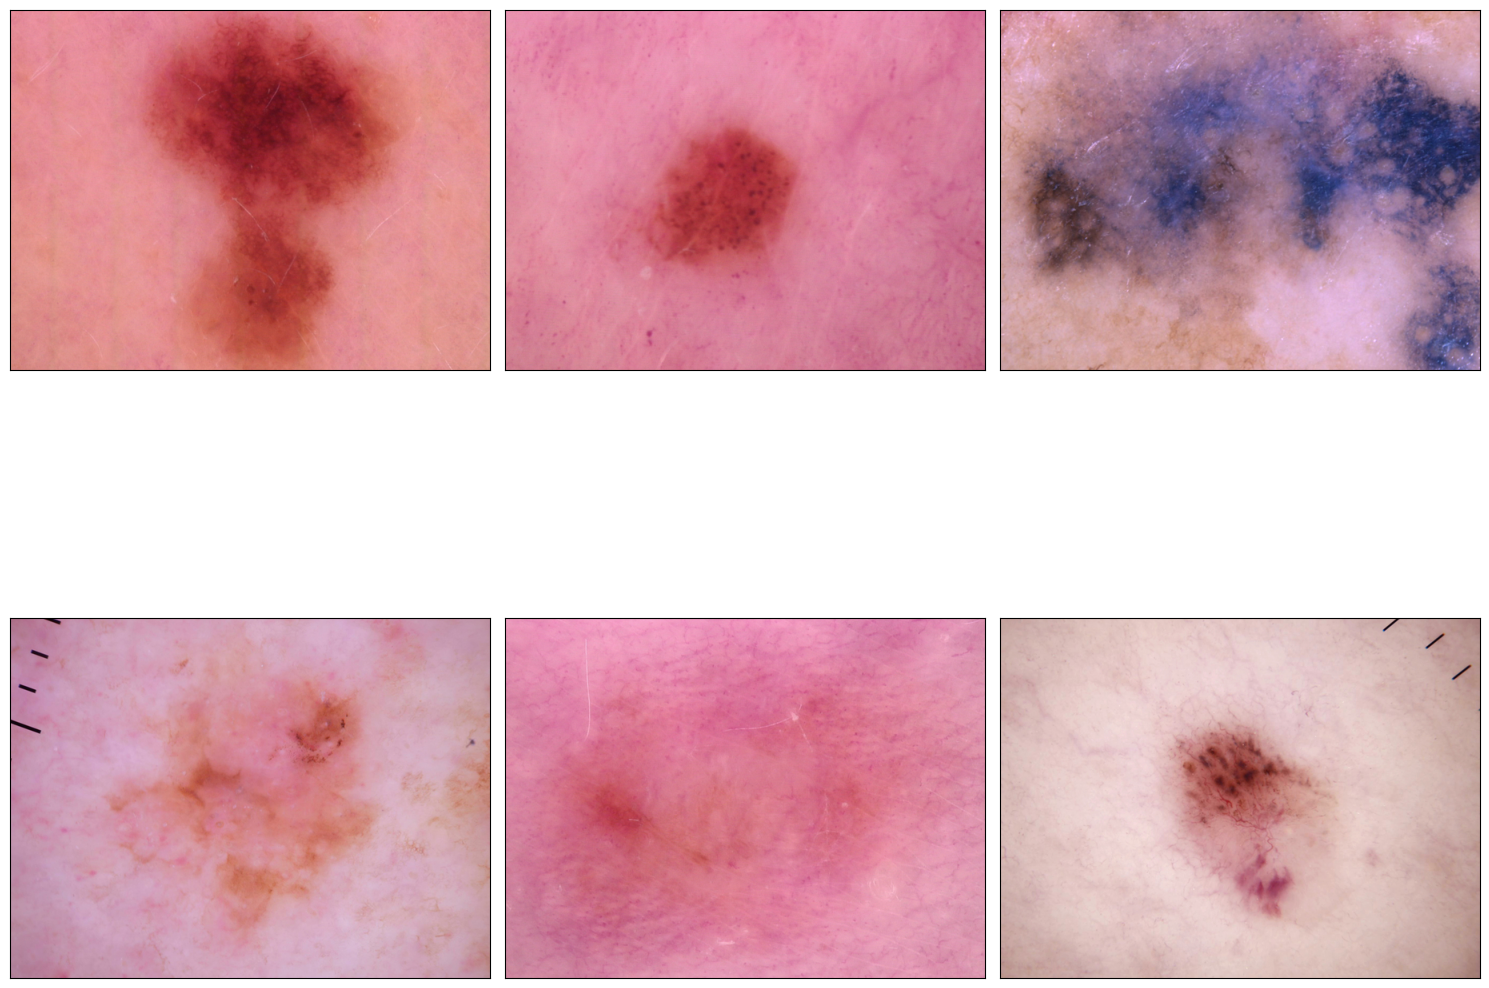

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Visualization
if all_image_path:
    w, h = 10, 10
    fig = plt.figure(figsize=(15, 15))
    columns, rows = 3, 2
    start, end = 0, len(all_image_path) - 1
    ax = []
    for i in range(columns * rows):
        k = random.randint(start, end)
        img = mpimg.imread((all_image_path[k]))
        ax.append(fig.add_subplot(rows, columns, i + 1))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap="gray")
    plt.tight_layout()
    plt.show()
else:
    print("No images found in the specified directory.")

In [ ]:
normMean = [0.7630358, 0.54564357, 0.5700475]
normStd = [0.14092763, 0.15261263, 0.16997081]

df_undup = df_original.groupby('lesion_id').count()
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)

def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

df_original['duplicates'] = df_original['lesion_id']
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_undup = df_original[df_original['duplicates'] == 'unduplicated']

y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)

def get_val_rows(x):
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_original['train_or_val'] = df_original['image_id']
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
df_train = df_original[df_original['train_or_val'] == 'train']

In [ ]:
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]
augmented_df_list = [df_train]

for i in range(7):
    if data_aug_rate[i] > 1:
        df_to_augment = df_train[df_train['cell_type_idx'] == i]
        augmented_df_list.append(pd.concat([df_to_augment] * (data_aug_rate[i] - 1), ignore_index=True))

df_train = pd.concat(augmented_df_list, ignore_index=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [ ]:
df_train_subset = df_train.sample(frac=0.1, random_state=101)
df_val_subset = df_val.sample(frac=0.1, random_state=101)

In [ ]:
class PretrainedResNext(nn.Module):
    def __init__(self, num_class=7):
        super().__init__()
        resNext = models.resnext101_32x8d(pretrained=True)
        self.channels = resNext.fc.out_features
        for params in resNext.parameters():
            params.requires_grad_(False)
        self.features = nn.Sequential(*list(resNext.children()))
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(self.channels, num_class)
        self.softmax = nn.Softmax()

    def forward(self, x):
        features = self.features(x)
        out = self.relu(features)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(-1, self.channels)
        out = self.fc1(out)
        out = self.softmax(out)
        return out

model = PretrainedResNext()
model_ft = models.resnext101_32x8d(pretrained=True)
model_ft.fc = nn.Linear(in_features=2048, out_features=7)
model = model_ft

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:02<00:00, 163MB/s]


In [ ]:
input_size = 224
train_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(normMean, normStd)])
val_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(normMean, normStd)])

In [ ]:
df_train_subset = df_train.sample(frac=0.1, random_state=101).reset_index(drop=True)
df_val_subset = df_val.sample(frac=0.1, random_state=101).reset_index(drop=True)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.loc[index, 'path']
        X = Image.open(img_path)
        y = torch.tensor(int(self.df.loc[index, 'cell_type_idx']))

        if self.transform:
            X = self.transform(X)
        return X, y

In [ ]:
# Create Custom Dataset and DataLoader with reduced workers and no pin_memory
batch_size = 16  # Keep the reduced batch size

training_set = CustomDataset(df_train_subset, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False)
validation_set = CustomDataset(df_val_subset, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=False)

In [ ]:
# AverageMeter class definition
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Train and Validate Functions
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)

    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)
        train_loss.update(loss.item())
        curr_iter += 1

        if (i + 1) % 100 == 0:
            print(f'[epoch {epoch}], [iter {i + 1} / {len(train_loader)}], [train loss {train_loss.avg:.5f}], [train acc {train_acc.avg:.5f}]')

    # Append average loss and accuracy to the lists
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)

In [ ]:
def validate(val_loader, model, criterion, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            prediction = outputs.max(1, keepdim=True)[1]
            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)
            val_loss.update(loss.item())

    # Append average loss and accuracy to the lists
    total_loss_val.append(val_loss.avg)
    total_acc_val.append(val_acc.avg)
    print(f'[epoch {epoch}], [val loss {val_loss.avg:.5f}], [val acc {val_acc.avg:.5f}]')
    return val_acc.avg

In [ ]:
# Main Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epoch_num = 5
best_val_acc = 0

for epoch in range(1, epoch_num + 1):
    train(train_loader, model, criterion, optimizer, epoch)
    val_acc = validate(val_loader, model, criterion, epoch)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Best model saved with accuracy: {best_val_acc:.5f}')

[epoch 1], [iter 100 / 430], [train loss 1.29878], [train acc 0.60062]
[epoch 1], [iter 200 / 430], [train loss 1.24524], [train acc 0.60594]
[epoch 1], [iter 300 / 430], [train loss 1.19902], [train acc 0.61583]
[epoch 1], [iter 400 / 430], [train loss 1.17790], [train acc 0.62109]


NameError: name 'total_loss_train' is not defined